# import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# from datetime import datetime
# from urllib.request import urlopen


# from bs4 import BeautifulSoup
# from requests import get


In [2]:
import helpers

# scrape all pages

## To scrape fresh data

In [3]:
# raw_scraped_data = helpers.scrape_housing_data()

In [4]:
# raw_scraped_data.head()

In [5]:
# raw_scraped_data.to_csv('raw_scraped_data.csv', index=0)

## To import already scraped data:

In [6]:
raw_scraped_data = pd.read_csv('raw_scraped_data.csv')
raw_scraped_data.head()

,url,description,price,square_feet,bedrooms,neighborhood
0,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,QUIET NORTH BEACH STUDIO W/ PRIVATE DECK & GARDEN,2200.0,NaN,1.0,north beach / telegraph hill
1,https://sfbay.craigslist.org/nby/apa/d/petalum...,Closed to all YOur Need @ WoodCreek Apartments!!,2199.0,700.0,2.0,petaluma
2,https://sfbay.craigslist.org/sby/apa/d/cuperti...,"Private Balconies, Call for Details, Stylish F...",4762.0,1291.0,2.0,cupertino
3,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,"When Minutes Matter, Live Where You Work and Play",3790.0,728.0,1.0,soma / south beach
4,https://sfbay.craigslist.org/sby/apa/d/milpita...,"3 Bed - 3 Bath, Pickle Ball, Mountain view-Up ...",5810.0,1753.0,3.0,milpitas


# cleaning

In [7]:
cleaned_data = raw_scraped_data.pipe(helpers.all_cleaning).pipe(helpers.filter_to_popular_neighborhoods)


In [8]:
# save cleaned data to .csv
cleaned_data.to_csv('craigslist_bay_area_rentals.csv')

# transform feaures

Very simple: just engineer one feature, price per room.

In [9]:
transformed_data = helpers.transform_features(cleaned_data)

transformed_data.head()

,url,description,neighborhood,price,bedrooms,price_per_room
3,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,"When Minutes Matter, Live Where You Work and Play",soma/south beach,3790.0,1.0,3790.0
5,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,Studio in a Building w/Amazing Amenities,san francisco,2200.0,1.0,2200.0
6,https://sfbay.craigslist.org/sby/apa/d/mountai...,2x1 in Sunny Location! Call for more info,mountain view,3240.0,2.0,1620.0
9,https://sfbay.craigslist.org/pen/apa/d/mountai...,1 Bed x 1 Bath ! Bring your furry pal along!,mountain view,2990.0,1.0,2990.0
12,https://sfbay.craigslist.org/sfc/apa/d/san-fra...,$3000 Off March rent if moving in by 3/6!! Com...,soma/south beach,6596.0,2.0,3298.0


In [10]:
transformed_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1265 entries, 3 to 2998
Data columns (total 6 columns):
url               1265 non-null object
description       1265 non-null object
neighborhood      1265 non-null object
price             1265 non-null float64
bedrooms          1265 non-null float64
price_per_room    1265 non-null float64
dtypes: float64(3), object(3)
memory usage: 69.2+ KB


# visualize

In [15]:
max_neighborhoods_set = list(set(cleaned_data['neighborhood']))
# max_neighborhoods_set

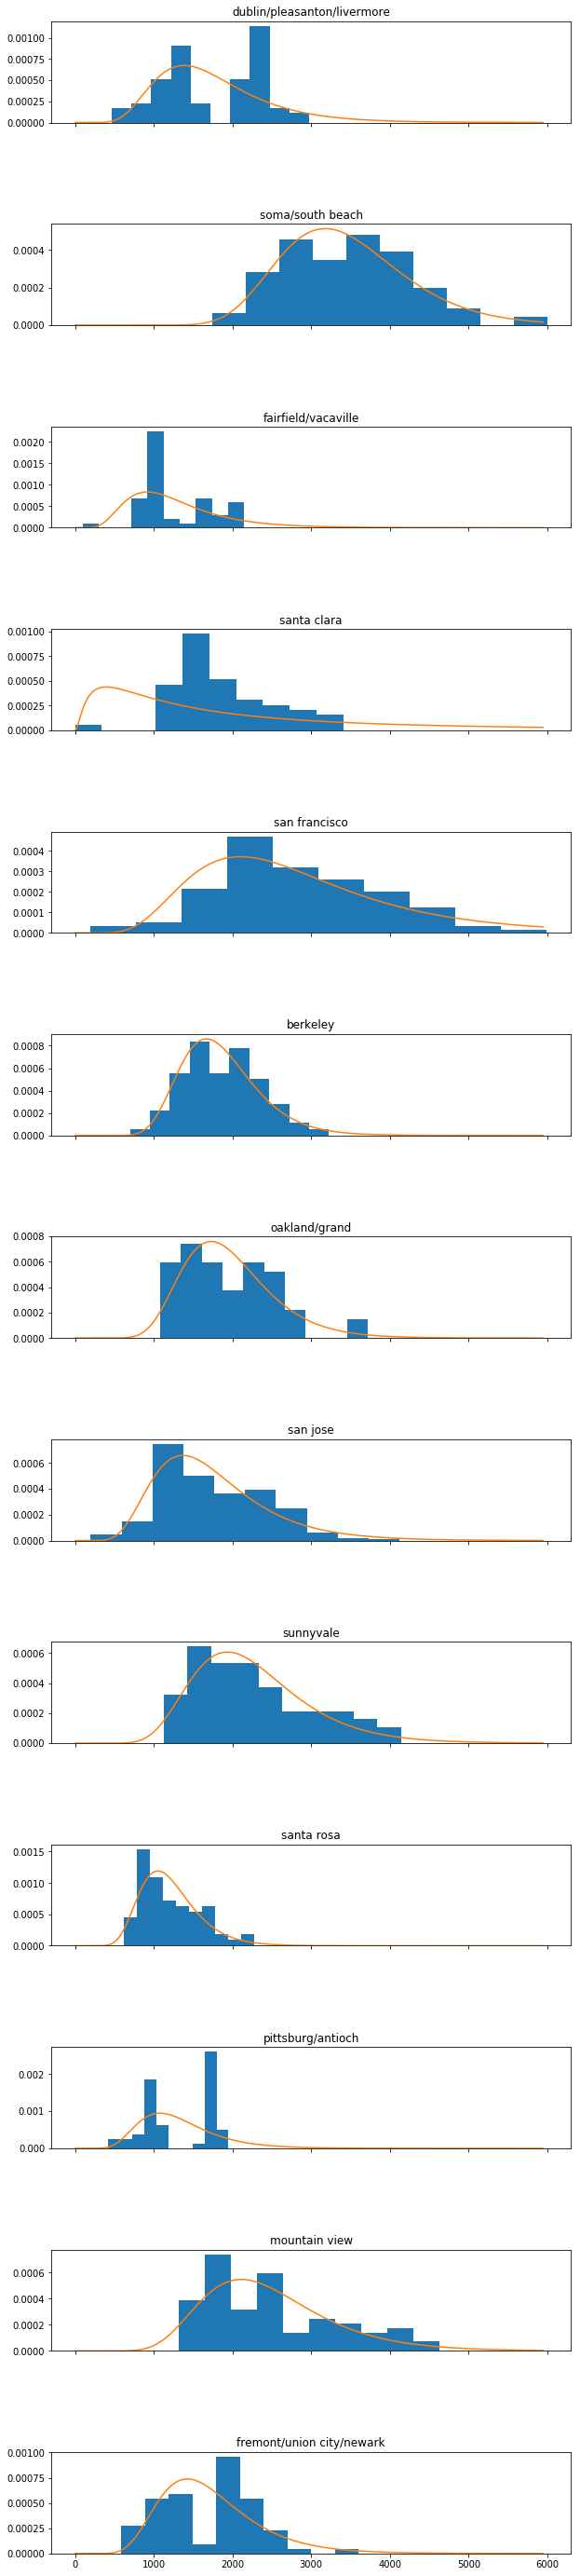

In [16]:
helpers.plot_price_distr(transformed_data)#, neighborhoods = ['santa rosa'])

# detect outliers using log normal distribution

In [13]:
low_outliers_df = helpers.get_outliers(transformed_data)

In [14]:
import numpy as np
from IPython.core.display import display, HTML

# display a useful link to the listings marked as low-price outliers:
def display_link(row):
    
    link = display(HTML(f"<a href={row['url']} target='_blank'> ${np.round(row['price_per_room'])} per room in a {row['neighborhood'].capitalize()} {row['bedrooms']}-bedroom. </a>"))
    
    return link
    
for row in [low_outliers_df.iloc[i] for i in range(len(low_outliers_df))]:
    display_link(row)



# TO DO:

1. Sometimes this misrepresents rent per room, e.g. if someone is renting out just 1 room in a 2-bedroom, and has listed rent for just the 1 room, but has posted the listing as a "2-bedroom". Can I find a way to correct this error by looking for particular words in the description/title?
e.g. try to clean "bedrooms" data by checking description for "room available in". if it's there, probably should set "becrooms" = 1.0.
2. Many of the price distributions look kinda bimodal. Should explore this and consider using a different distribution with which to define outliers.